### CMPE 252 : Artificial Intelligence and Data Engineering [Spring 2023]
### Home Assignment 2
### Probabilistic Reasoning in Dynamical Systems - Kalman Filter


In [13]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [14]:
# Initialise variable values

A = np.array([[0.99951, 0.00999837], [-0.09784, 0.99951]])
C = np.array([0,1])

mu_mean = np.array([0, 0])
mu_cov = np.array([[1.00207*10**(-7), 4.31094*10**(-8)], [4.31094*10**(-8), 9.6011*10**(-6)]])

v_mean = 0
v_var = 0.01

x0 = np.array([0.1, 0.0]) # initial state


In [15]:
#Dynamics Model
dynamics = lambda x: np.matmul(A, x) + np.random.multivariate_normal(mu_mean, mu_cov, 1)

#Measurement Model
observation = lambda x: np.matmul(C, x) + np.random.normal(v_mean, v_var)

### Question 1
Starting from x[0] = [0.1;0.0], simulate the pendulum
dynamics for T = 499 steps, where mu[k] is sampled from the
two dimensional Gaussian with the mean mu_mean, and the
covariance mu_cov, and v[k] is sampled from the one dimensional
Gaussian with the mean v_mean, and variance, v_var.

The simulated state and observation trajectories are arrays
with dimensions 2 x 500 and 1 x 500, respectively. (In practice, the true state is unknown.)

In [16]:
def simulate_pendulum_dynamics(T, x0):

  sim_state = np.empty((2,T))
  obs_trajectory = np.empty((1,T))

  x = x0
  for i in range(T):

    x1 = dynamics(x)
    y = observation(x)

    x1 = np.transpose(x1).reshape((2,))
    #print(i, x1, y)
    
    sim_state[0][i], sim_state[1][i] = x1[0], x1[1]
    obs_trajectory[0][i] = y

    x = x1 # assign next state as current state

  return sim_state, obs_trajectory

T = 500
time = range(1,T+1)

simulated_state, obs_trajectory = simulate_pendulum_dynamics(T, x0)


### Question 2
Plot the following on the same figure as a function of time. Add the legend.
*   the true angle x[1:], 
*   true angular velocity x[2:], and
*   the measured noisy angular velocity y[:]


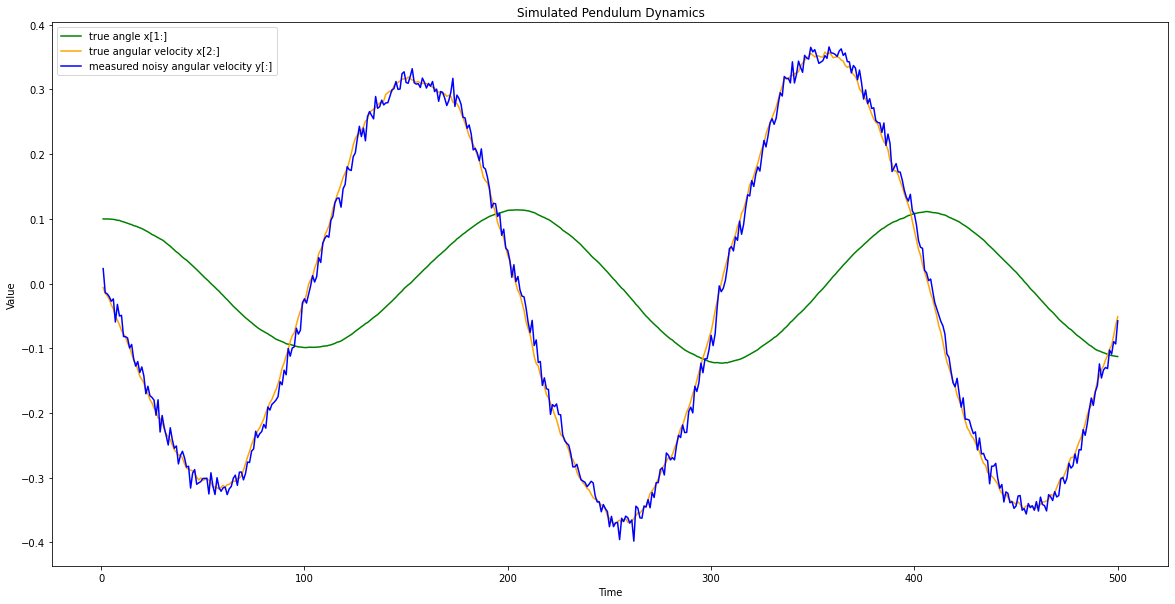

In [18]:
plt.plot(time, simulated_state[0][:], color = "green", label="true angle x[1:]")
plt.plot(time, simulated_state[1][:], color = "orange", label="true angular velocity x[2:]")
plt.plot(time, obs_trajectory[0][:], color = "blue", label="measured noisy angular velocity y[:]")

plt.rcParams['figure.figsize'] = [20, 10]
plt.legend(loc="upper left")
plt.title("Simulated Pendulum Dynamics")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

### Question 3
State reconstruction by Kalman filter:



#### Question 3.1
Calculate recursively the state estimation covariance matrix,
De+ije, for t € [1,500]. Assume
Yoj-1 = le7? * 'IdentityMartrix’s,..
See Slide 8-18 at
https://stanford.edu/class/ee363/lectures/kf.pdf


In [23]:
def state_estimation_covariance(x0):

  next_state_cov = lambda x : np.matmul(np.matmul(A, x), np.transpose(A)) + mu_cov
  
  x = x0
  for i in range(1, T+1):
    x1 = next_state_cov(x)
    x = x1

  return x

I_2x2 = np.array([[1, 0], [0, 1]])
ini_cov = 10**(-3) * I_2x2 # initial state
state_estimation_cov_mat = state_estimation_covariance(ini_cov)
state_estimation_cov_mat

array([[0.0012664 , 0.00018763],
       [0.00018763, 0.00367379]])

#### Question 3.2
Reconstruct the full state, X,1)+, for t € [1,500] from the
sensor readings, y|:], only. Assume Xo)-1 = [0.1; 0]. See Slide
8-20. (x(1,:] and x[2, :] are unknown /hidden. )

In [20]:
def full_state_reconstruction(x0):

  x = x0
  state_reconstruction_mat = np.empty((2,T+1))
  state_reconstruction_mat[0][0], state_reconstruction_mat[1][0] = x[0], x[1]
  
  reconstruct_next_state = lambda x : np.matmul(A, x)

  for i in range(1, T+1):
    x1 = reconstruct_next_state(x)
    state_reconstruction_mat[0][i], state_reconstruction_mat[1][i] = x1[0], x1[1]
    x = x1
  
  return state_reconstruction_mat

state_reconstruction_mat = full_state_reconstruction(x0)

### Question 4 
Add to the previous plot X;41/¢[1, :], %:41)2[2, :], and Yes apel[:]-
Add legend. Explain your observations.

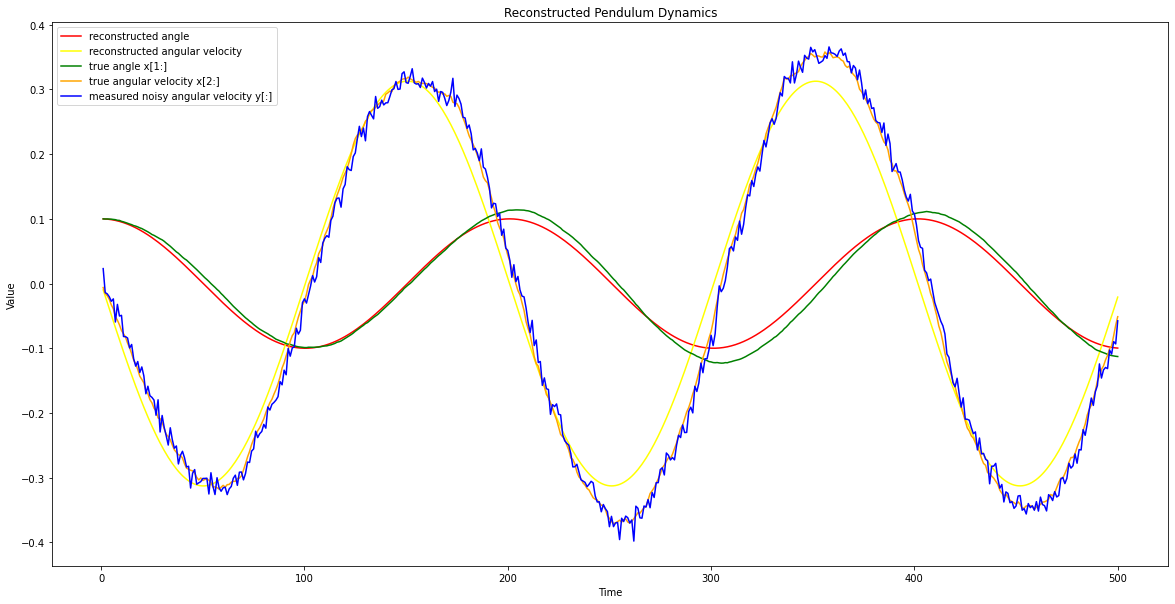

In [21]:
plt.plot(time, state_reconstruction_mat[0][1:], color = "red",label="reconstructed angle")
plt.plot(time, state_reconstruction_mat[1][1:], color = "yellow",label="reconstructed angular velocity")
plt.plot(time, simulated_state[0][:], color = "green", label="true angle x[1:]")
plt.plot(time, simulated_state[1][:], color = "orange", label="true angular velocity x[2:]")
plt.plot(time, obs_trajectory[0][:], color = "blue", label="measured noisy angular velocity y[:]")

plt.rcParams['figure.figsize'] = [16, 8]
plt.legend(loc="upper left")
plt.title("Reconstructed Pendulum Dynamics")
plt.xlabel("Time")
plt.ylabel("Value")

plt.show()

### Question 5 
Repeat 10 times the questions 1, 3.1, and 3.2. Plots all the
curves on the same plot as a function of time, and explain the
meaning of the variance of the curves for %41)[1, :], Xe ael2, :], and Yesael'l.